Install Kaggle


In [10]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("praneet0327/brain-tumor-dataset")
print("Dataset downloaded to:", path)


100%|██████████| 100M/100M [00:05<00:00, 18.1MB/s] 

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1


Splitting data

In [11]:
import os, shutil, random

source_root = "/root/.cache/kagglehub/datasets/praneet0327/brain-tumor-dataset/versions/1/Brain_Tumor_Dataset"
classes = ["Negative", "Positive"]   # <--- your actual folder names

output_root = "data_split"
os.makedirs(output_root, exist_ok=True)

# create subfolders
for subset in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_root, subset, cls), exist_ok=True)

for cls in classes:
    src = os.path.join(source_root, cls)
    imgs = os.listdir(src)
    random.shuffle(imgs)

    n = len(imgs)
    train_end = int(0.7 * n)
    val_end = train_end + int(0.15 * n)

    print(f"{cls}: total={n}, train={train_end}, val={val_end-train_end}, test={n-val_end}")

    for i, img in enumerate(imgs):
        if i < train_end:
            subset = "train"
        elif i < val_end:
            subset = "val"
        else:
            subset = "test"

        shutil.copy(
            os.path.join(src, img),
            os.path.join(output_root, subset, cls, img)
        )

print("DONE SPLITTING!")


Negative: total=2000, train=1400, val=300, test=300
Positive: total=3266, train=2286, val=489, test=491
DONE SPLITTING!


Testing

In [12]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===== DATA LOADERS =====

def get_dataloaders(data_root="data_split", batch_size=32, num_workers=2):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = datasets.ImageFolder(os.path.join(data_root, "train"), transform=train_transform)
    val_dataset   = datasets.ImageFolder(os.path.join(data_root, "val"),   transform=test_transform)
    test_dataset  = datasets.ImageFolder(os.path.join(data_root, "test"),  transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Classes:", train_dataset.classes)
    return train_loader, val_loader, test_loader, train_dataset.classes


# ===== MODEL =====

def get_resnet50_model(num_classes=1, pretrained=True):
    model = models.resnet50(pretrained=pretrained)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    return model


def unfreeze_last_layers(model):
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True


# ===== TRAIN & EVAL =====

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()

        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # FIX 1
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

    epoch_loss = running_loss / len(dataloader.dataset)
    return (
        epoch_loss,
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs)
    )


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.float().to(device)

        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        # FIX 2
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

    epoch_loss = running_loss / len(dataloader.dataset)
    return (
        epoch_loss,
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs)
    )


# ===== MAIN TRAINING =====

def main():
    data_root = "data_split"
    batch_size = 32
    base_epochs = 10
    finetune_epochs = 10
    lr_head = 1e-3
    lr_finetune = 5e-5

    train_loader, val_loader, test_loader, _ = get_dataloaders(data_root=data_root, batch_size=batch_size)

    model = get_resnet50_model(num_classes=1, pretrained=True).to(device)
    criterion = nn.BCEWithLogitsLoss()

    print("\n=== Stage 1: Training classifier head ===")
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_head)

    best_val_f1 = 0
    best_state = None

    for epoch in range(base_epochs):
        t = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{base_epochs} | Train Acc={t[1]:.4f} F1={t[2]:.4f} | Val Acc={v[1]:.4f} F1={v[2]:.4f}")

        if v[2] > best_val_f1:
            best_val_f1 = v[2]
            best_state = model.state_dict()

    print("\n=== Stage 2: Fine-tuning deeper layers ===")
    unfreeze_last_layers(model)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_finetune)

    for epoch in range(finetune_epochs):
        t = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v = evaluate(model, val_loader, criterion, device)

        print(f"[FT] Epoch {epoch+1}/{finetune_epochs} | Train Acc={t[1]:.4f} F1={t[2]:.4f} | Val Acc={v[1]:.4f} F1={v[2]:.4f}")

        if v[2] > best_val_f1:
            best_val_f1 = v[2]
            best_state = model.state_dict()

    model.load_state_dict(best_state)

    test_loss, acc, f1, prec, rec, auc = evaluate(model, test_loader, criterion, device)

    print("\n=== FINAL TEST METRICS ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"AUC-ROC    : {auc:.4f}")

    torch.save(model.state_dict(), "brain_tumor_resnet50.pth")
    print("Model saved as brain_tumor_resnet50.pth")


main()


Using device: cuda
Classes: ['Negative', 'Positive']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]



=== Stage 1: Training classifier head ===
Epoch 1/10 | Train Acc=0.8424 F1=0.8789 | Val Acc=0.9100 F1=0.9226
Epoch 2/10 | Train Acc=0.9137 F1=0.9313 | Val Acc=0.9493 F1=0.9602
Epoch 3/10 | Train Acc=0.9257 F1=0.9409 | Val Acc=0.9582 F1=0.9654
Epoch 4/10 | Train Acc=0.9273 F1=0.9421 | Val Acc=0.9556 F1=0.9632
Epoch 5/10 | Train Acc=0.9360 F1=0.9486 | Val Acc=0.9645 F1=0.9713
Epoch 6/10 | Train Acc=0.9300 F1=0.9440 | Val Acc=0.9632 F1=0.9699
Epoch 7/10 | Train Acc=0.9324 F1=0.9458 | Val Acc=0.9721 F1=0.9773
Epoch 8/10 | Train Acc=0.9357 F1=0.9485 | Val Acc=0.9670 F1=0.9733
Epoch 9/10 | Train Acc=0.9327 F1=0.9459 | Val Acc=0.9696 F1=0.9751
Epoch 10/10 | Train Acc=0.9395 F1=0.9514 | Val Acc=0.9632 F1=0.9706

=== Stage 2: Fine-tuning deeper layers ===
[FT] Epoch 1/10 | Train Acc=0.9710 F1=0.9766 | Val Acc=0.9949 F1=0.9959
[FT] Epoch 2/10 | Train Acc=0.9883 F1=0.9906 | Val Acc=0.9949 F1=0.9959
[FT] Epoch 3/10 | Train Acc=0.9938 F1=0.9950 | Val Acc=0.9962 F1=0.9969
[FT] Epoch 4/10 | Train Ac

In [13]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


True
Tesla T4


CHECKING

Using device: cuda

=== TEST SET METRICS ===
Accuracy   : 0.9975
F1-score   : 0.9980
Precision  : 0.9959
Recall     : 1.0000
AUC-ROC    : 0.9997


Saving images.jpg to images (1).jpg


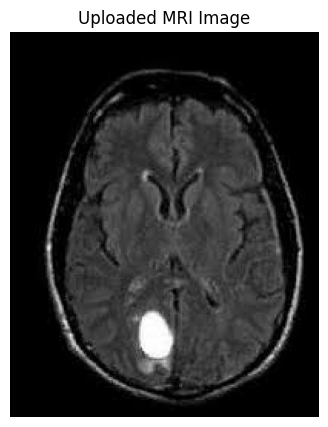

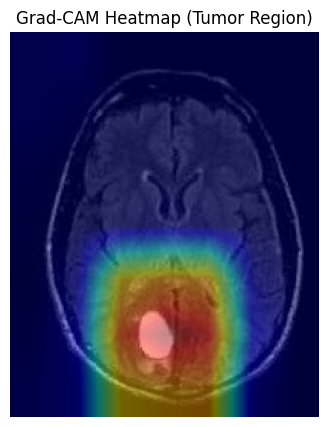

Tumor Probability     : 100.0000%
Final Prediction      : Tumor


In [24]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Load model (same arch as training) ----
# Assumes get_resnet50_model is already defined in an earlier cell
model = get_resnet50_model(num_classes=1, pretrained=False)
model.load_state_dict(torch.load("brain_tumor_resnet50.pth", map_location=device))
model.to(device)
model.eval()

# ---- Transform (same as training) ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---------- Grad-CAM setup (hook on last conv block) ----------
activations = None

def forward_hook(module, inp, out):
    global activations
    activations = out  # [1, C, H, W]

# hook last block of layer4
target_layer = model.layer4[-1]
target_layer.register_forward_hook(forward_hook)

# -------- New: evaluate on FULL test set for metrics --------
def evaluate_on_test(test_root="data_split/test", batch_size=32):
    test_dataset = datasets.ImageFolder(test_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_labels = []
    all_probs = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= 0.5).long().cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print("\n=== TEST SET METRICS ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"AUC-ROC    : {auc:.4f}")

# -------- Single image prediction + Grad-CAM --------
def predict_image_with_gradcam(img_path):
    global activations

    # Load original image
    img = Image.open(img_path).convert("RGB")

    # Show original uploaded MRI
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded MRI Image")
    plt.show()

    # Preprocess
    x = transform(img).unsqueeze(0).to(device)
    x.requires_grad_(True)   # enable gradient tracking for input

    # Forward pass
    model.zero_grad()
    out = model(x).squeeze(1)      # [1] -> scalar
    logit = out.view(-1)[0]
    prob = torch.sigmoid(logit).item()

    # Grad-CAM: gradients of logit w.r.t activations from hooked layer
    grads = torch.autograd.grad(logit, activations, retain_graph=False, create_graph=False)[0]  # [1, C, H, W]
    acts = activations                                            # [1, C, H, W]

    grads = grads[0]   # [C, H, W]
    acts = acts[0]     # [C, H, W]

    # Global average pool gradients -> channel weights
    weights = grads.mean(dim=(1, 2))  # [C]

    # Weighted sum of activations
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)  # [H, W]
    for c, w in enumerate(weights):
        cam += w * acts[c]

    cam = torch.relu(cam)

    # Normalize CAM to [0,1]
    cam = cam.detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Resize CAM to original image size
    cam_img = Image.fromarray(np.uint8(cam * 255)).resize(img.size, resample=Image.BILINEAR)
    cam_img = np.array(cam_img) / 255.0

    # Overlay heatmap on original image
    plt.figure(figsize=(6,5))
    plt.imshow(img)
    plt.imshow(cam_img, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap (Tumor Region)")
    plt.show()

    tumor_prob = prob * 100
    print(f"Tumor Probability     : {tumor_prob:.4f}%")
    print(f"Final Prediction      : {'Tumor' if prob >= 0.5 else 'No Tumor'}")


# ---- 1) Evaluate metrics on whole test set ----
evaluate_on_test()

# ---- 2) Upload and test a single image (with Grad-CAM) ----
from google.colab import files
uploaded = files.upload()

first_fname = next(iter(uploaded))
predict_image_with_gradcam(first_fname)
